# 영화리뷰 텍스트 감성분석하기 

## 학습 목표
- 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.
- RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.
- 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.
- IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성 분류 실습을 진행한다.

 ### 용어 정리
 
- 워드 임베딩(word embedding) 기법 : 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법(단어의 특성을 저차원 벡터값으로 표현함)
- join () : 모든 반복 자료형의 데이터를 하나의 문자열로 합치는 기능을 수행함.
- ed_sentence ; 인덱싱된 것을 매핑된 것으로 확인 가능함.
ex) eat 이 6번으로 인덱싱되면,그것을 확인하는 것을 매핑이라고 이야기함.
- vocab_size : 어휘 사전의 크기(사전 안의 단어개수를 표현)
- tokenizer : 보통 공백, 구두점, 특수문자 등으로 text를 여러개의 token으로 나누는 함수.
- token : 문법적으로 더 이상 나눌 수 없는 언어요소를 뜻
- decode() : 수치데이터에서 다시 원래 데이터로 복구 시키는 것.
- word_vector_dim : 단어 하나를 표현하는 임베딩 벡터의 차원 수
- GlobalMaxPooling1D() 레이어  : 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식
- imdb.load_data() 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됨.
- np.std() : 표준편차 구하기
- model.compile() : 학습과정 설정 ex) optimizer, loss(손실값), metrics(평가지표)
- weights = model.get_weights():모델의 시냅스 가중치 (weights)를 weights 변수에 저장하고 출력
- 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조여야 하며, 단순히 인덱싱으로 끝내는 것이 아니라 단어의 의미를 나타내는 벡터를 짝지어 보기위해서 단어의 의미를 나타내는 벡터를 훈련가능한 파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화시킴

## 라이브러리 Import

In [1]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

## 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [32]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
index_to_word = {index:word for word, index in word_to_index.items()}
len(word_to_index)

9997

## 모델 구성을 위한 데이터 분석 및 가공

In [4]:
# print(word_to_index)

In [5]:
imdb = tf.keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [6]:
# 데이터셋 내 문장 길이 분포
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [7]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])    
print(word_to_index['the']) 

1654784/1641221 [==============================] - 0s 0us/step
the
1


In [8]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있음.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}


word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     
print(word_to_index['the'])  
print(index_to_word[4])     

<BOS>
4
the


In [11]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [12]:
# 적절한 최대 문장 길이 지정
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


## 모델 구성 

In [33]:
#1 RNN 모델 적용

vocab_size = 10000    
word_vector_dim = 16  


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [34]:
#  1-D CNN 모델 적용
vocab_size = 10  
word_vector_dim = 4   

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [35]:
# GlobalMaxPooling1D() 레이어만 적용하는 모델
vocab_size = 10  
word_vector_dim = 4   

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 4)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [10]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

##  validation set 구성

In [15]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


## 모델 훈련 개시

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 20s 45ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.5019
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6928 - accuracy: 0.5120 - val_loss: 0.6931 - val_accuracy: 0.5021
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6920 - accuracy: 0.5212 - val_loss: 0.6934 - val_accuracy: 0.5018
Epoch 4/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6899 - accuracy: 0.5239 - val_loss: 0.6923 - val_accuracy: 0.5074
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6861 - accuracy: 0.5222 - val_loss: 0.6917 - val_accuracy: 0.5045
Epoch 6/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6776 - accuracy: 0.5279 - val_loss: 0.6910 - val_accuracy: 0.5053
Epoch 7/20
30/30 [==============================] - 1s 29ms/step - loss: 0.6682 - accuracy: 0.5358 - val_loss: 0.6932 - val_accuracy: 0.5060
Epoch 8/20
3

In [17]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.7157 - accuracy: 0.5111
[0.7157159447669983, 0.5111200213432312]


## Loss, Accuracy 그래프 시각화

In [18]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


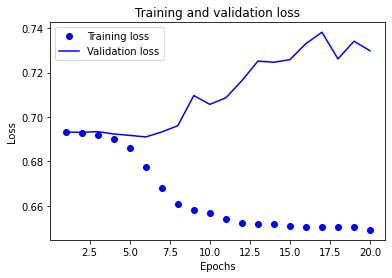

In [19]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

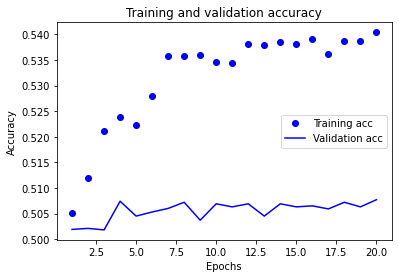

In [20]:
plt.clf()   # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [1]:
!pip install gensim

!pip install --upgrade gensim==3.8.3

In [2]:
import gensim

gensim.__version__

'3.8.3'

In [21]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [22]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([ 0.01038649,  0.05601869,  0.09914727,  0.08264274, -0.12424193,
        0.06797822, -0.07115102, -0.1307802 , -0.03022096, -0.00067527,
        0.01936306, -0.02078599, -0.00380445, -0.00357885, -0.02326724,
        0.01545132], dtype=float32)

In [24]:
word_vectors.similar_by_word("love")

[('walsh', 0.8290149569511414),
 ('mega', 0.7852738499641418),
 ('comprehend', 0.7791694402694702),
 ('iranian', 0.7575578689575195),
 ('raj', 0.7569407224655151),
 ('elsewhere', 0.7557183504104614),
 ('pointed', 0.7521834969520569),
 ('sum', 0.7517849802970886),
 ('needs', 0.7362785935401917),
 ('directions', 0.7325805425643921)]

In [25]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector   

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [26]:
vocab_size = 10000    
word_vector_dim = 300  수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)


for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [27]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 300  

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 114, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## 학습진행

In [28]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 14s 84ms/step - loss: 0.6955 - accuracy: 0.5191 - val_loss: 0.6899 - val_accuracy: 0.5338
Epoch 2/20
30/30 [==============================] - 2s 66ms/step - loss: 0.6827 - accuracy: 0.5623 - val_loss: 0.6814 - val_accuracy: 0.6004
Epoch 3/20
30/30 [==============================] - 2s 66ms/step - loss: 0.6592 - accuracy: 0.6276 - val_loss: 0.6493 - val_accuracy: 0.5917
Epoch 4/20
30/30 [==============================] - 2s 66ms/step - loss: 0.5226 - accuracy: 0.7580 - val_loss: 0.4163 - val_accuracy: 0.8191
Epoch 5/20
30/30 [==============================] - 2s 66ms/step - loss: 0.3193 - accuracy: 0.8693 - val_loss: 0.3322 - val_accuracy: 0.8566
Epoch 6/20
30/30 [==============================] - 2s 66ms/step - loss: 0.2189 - accuracy: 0.9198 - val_loss: 0.3111 - val_accuracy: 0.8688
Epoch 7/20
30/30 [==============================] - 2s 67ms/step - loss: 0.1521 - accuracy: 0.9535 - val_loss: 0.3041 - val_accuracy: 0.8730
Epoch 8/20
3

# 모델평가

In [29]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.4998 - accuracy: 0.8632
[0.49976858496665955, 0.8632000088691711]


# Report

일반 텍스트등을 분석하기 위해서는 본 프로젝트처럼, 텍스트 데이터를 딕셔너리로 무엇을 기준으로 나눌 것인지 분류를 하는 작업이 필요하였으며
그 후, 인덱싱하여 반환시키고 벡터와 짝짓기위하여 embedding레이어를 활용하는 과정이 필요했음.

임베딩하는 단계에 넣기 위해서 데이터를 일정한 간격으로 맞추는 작업이 필요했고, 본 데이터들은 시퀀스 데이터로서 RNN, CNN,단독 Globalmax pooling 을 적용한 세가지 모델들을 적용을 함으로써 텍스트를 처리할 수가 있었음.

초기데이터들을 시각화시켰을 때, 3가지의 모델과 Validation set을 다 같이 적용 함에도 train set과의 validation loss가 차이가 컸음.

이에, Word2Vec모델을 새롭게 적용하였으며, 앞의 모델의 처리 기억들을 반영하기 위해서 가중치를 부여하여 훈련 시킴.

그럼으로써 accuracy가 86%가 되었음을 확인함.

## 기타 알게된 지식
-  Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다. raw_inputs의 3개 벡터의 길이 재확인 할 것 ,Tensorflow에서는tf.keras.preprocessing.sequence.pad_sequences라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공 
- maxlen : 패딩의 길이를 더 늘리고 싶거나, 단어의 나열 수가 너무 많아 길이를 짧게 하고 싶을 수 있는데, 이러한 경우 pad_sequences() 함수 안에 maxlen의 값을 입력해서 그 값을 지정해주면 됨. 따라서 max_len의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일하게 해줌.    
- embedding을 통하여 input값을 output로 반환할 때 shape는 (입력문장 개수, 입력문장 최대길이, 워드 벡터의 차원수)를 나타냄
- RNN(Recurrent Neural Network(RNN) : 시퀀스(Sequence) 형태 -(Ex,음성인식)의 데이터를 처리하기에 최적인 모델로서, 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 현재 상태를 묘사하는 state machine(그전에 입력된 것을 기억)으로 설계되어 있음.
- 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됨. RNN보다 병렬처리가 효율적임.
- IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word사용시, 실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있음.따라서, word_to_index = {k:(v+3) for k,v in word_to_index.items()} 이렇게 보정해줘야됨.
- padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생함.- RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됨. 따라서 'pre'가 훨씬 유리함.